색상 및 템플릿 추천 DA

In [121]:
template_recommend_num = 20

In [122]:
import json

with open(f"./product_template_matching.json", mode="r") as f:
    json_like = json.load(f)

datas = json_like
print("데이터 키:", list(datas[0].keys()))

데이터 키: ['fn', 'features', 'recommends', 'id']


데이터 변수화

In [123]:
colors_list = []
weights_list = []
recommends_colors_list = []
recommends_weights_list = []
ids_list = []

for data in datas:
    fn = data["fn"]

    colors = data["features"][0]
    weights = data["features"][1]
    recommends_colors = data["recommends"][0][0]
    recommends_weights = data["recommends"][1]
    ids = data["id"][:template_recommend_num]
    
    colors_list.extend(colors)
    weights_list.extend(weights)
    recommends_colors_list.extend(recommends_colors)
    recommends_weights_list.extend(recommends_weights)
    ids_list.extend(ids)

## 현재 데이터 분포

- 산포도 시각화 함수 정의

In [124]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_scatter(rgb_list):
    rgb_data = np.array(rgb_list)

    # Normalize the RGB values to [0, 1]
    normalized_rgb_data = rgb_data / 255.0

    # Create 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(rgb_data[:, 0], rgb_data[:, 1], rgb_data[:, 2], c=normalized_rgb_data)

    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')

    plt.show()


- 상품 색상 분포

In [125]:
import random

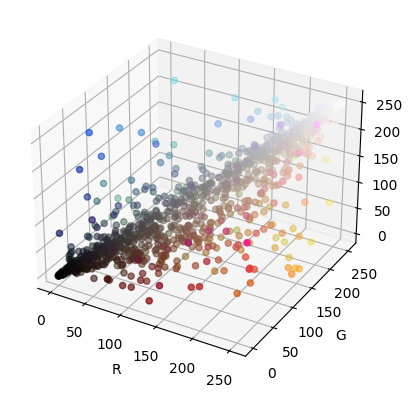

In [126]:
visualize_scatter(random.choices(colors_list,k=1000))

- AI 모델 추천 색상 분포

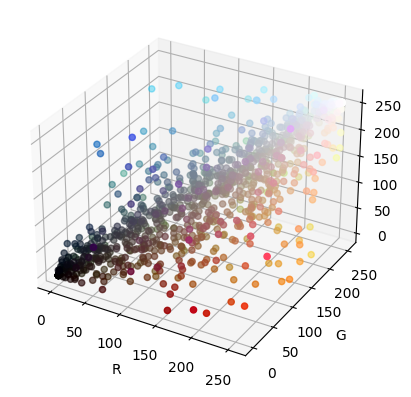

In [127]:
visualize_scatter(random.choices(recommends_colors_list, k=1000))

- 히스토그램 시각화 함수 정의

In [134]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_hisogram(rgb_list):    
    rgb_data = np.array(rgb_list)

    # Quantize the data for approximation
    quantized_data = rgb_data // 3

    # Create histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Histogram for R channel
    axs[0].hist(quantized_data[:, 0], bins=16, color='red', alpha=0.7, rwidth=0.85)
    axs[0].set_title('R Channel')
    axs[0].set_xlabel('R Value')
    axs[0].set_ylabel('Frequency')

    # Histogram for G channel
    axs[1].hist(quantized_data[:, 1], bins=16, color='green', alpha=0.7, rwidth=0.85)
    axs[1].set_title('G Channel')
    axs[1].set_xlabel('G Value')
    axs[1].set_ylabel('Frequency')

    # Histogram for B channel
    axs[2].hist(quantized_data[:, 2], bins=16, color='blue', alpha=0.7, rwidth=0.85)
    axs[2].set_title('B Channel')
    axs[2].set_xlabel('B Value')
    axs[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

- 상품 색상 히스토그램

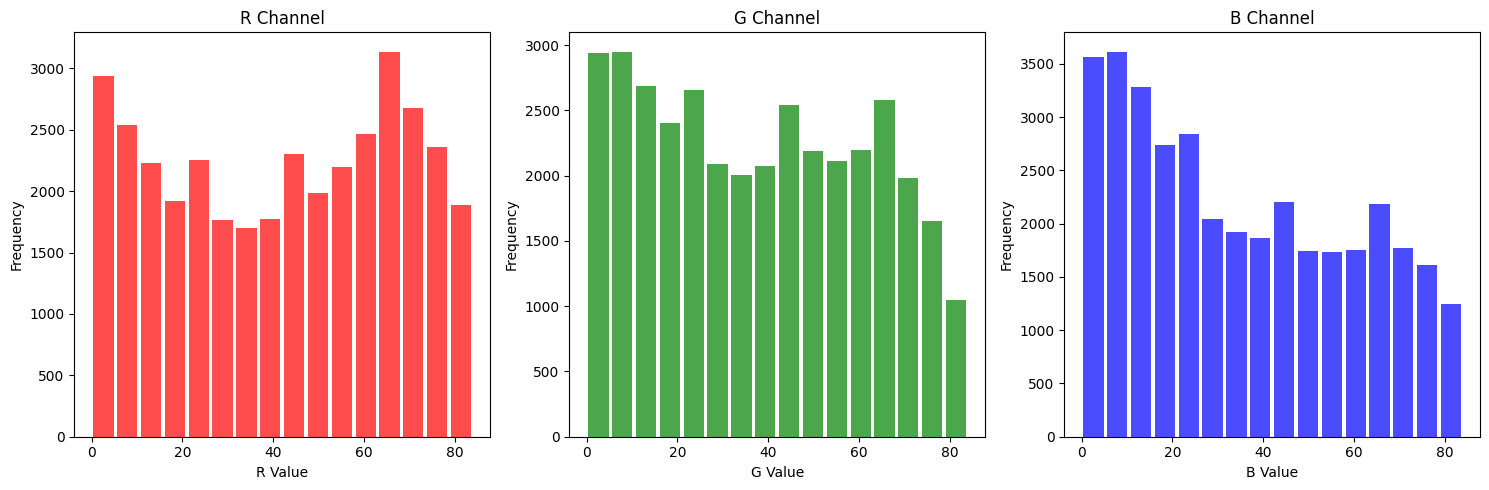

In [135]:
visualize_hisogram(colors_list)

- AI 모델 추천 색상 히스토그램

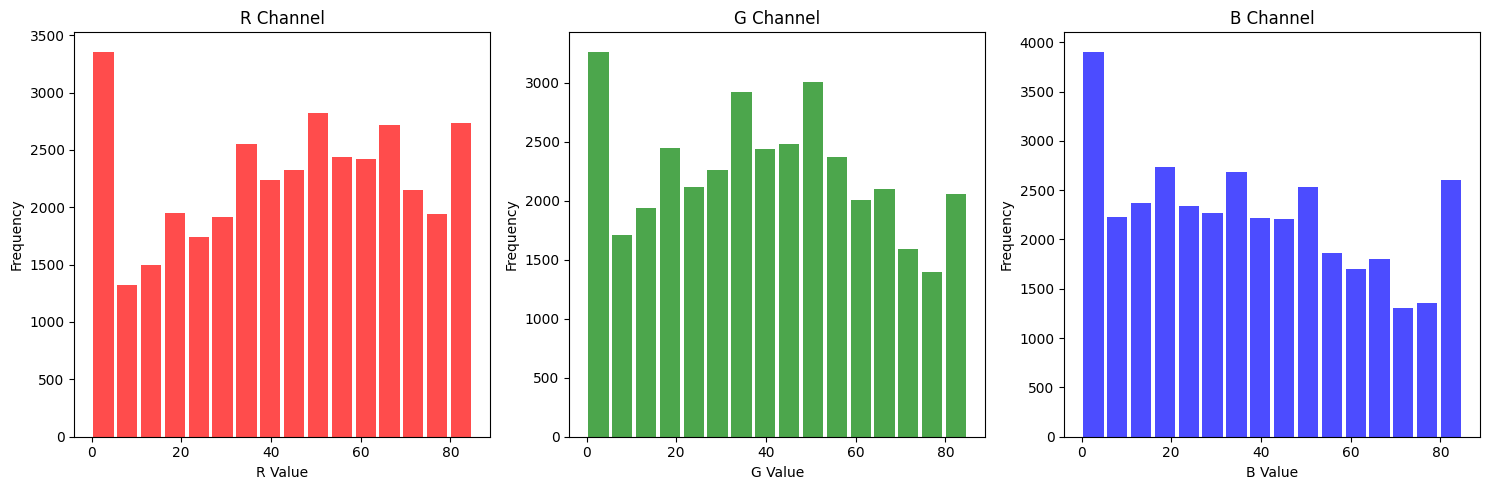

In [136]:
visualize_hisogram(recommends_colors_list)

## 템플릿 부족한 색상 영역, 추천 템플릿 편향성

템플릿 부족한 색상 영역 확인

In [137]:
import sys, os
current_dir = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(os.path.join(current_dir, '.'))
sys.path.append(os.path.join(current_dir, '..'))

In [138]:
from utils.data_utils import calculate_cos_similarity, get_close_index
def concat_array(arr1, arr2, axis=0):
    return np.concatenate([arr1, arr2], axis=axis)

In [139]:
from glob import glob
def load_templates_features():
    id_arr, colors_arr, weights_arr = [], [], []
    
    total_json = []

    fns = glob("../features/*.json")
    for fn in fns:
        with open(fn, 'r') as rf:
            total_json.extend(json.load(rf))
    
    for data in total_json:
        id_arr.append(data['id'])
        colors_arr.append(np.array(data['colors']).flatten())
        weights_arr.append(np.array(data['weights']).flatten())
    
    return np.array(id_arr), np.array(colors_arr), np.array(weights_arr)

In [140]:
np_colors_list = np.array(colors_list).reshape(-1,12)
np_weights_list = np.array(weights_list).reshape(-1,4)
np_rec_colors_list = np.array(recommends_colors_list).reshape(-1,12)
np_rec_weights_list = np.array(recommends_weights_list).reshape(-1,4)

In [141]:
id_arr, colors_arr, weights_arr = load_templates_features()

In [142]:
sims = []

for cur in concat_array(np_rec_colors_list, np_rec_weights_list*30, axis=1):
    sim = calculate_cos_similarity([cur], concat_array(colors_arr, weights_arr*30, axis=1))
    sims.append(sim)

In [146]:
sims = np.array(sims)
similarity_mean = np.mean(sims)
print("템플릿과 추천 색상간 평균 유사도:", similarity_mean)

템플릿과 추천 색상간 평균 유사도: 0.8045182101829261


In [147]:
top_sims = np.take_along_axis(sims, np.argsort(sims, axis=1)[:,-template_recommend_num:], axis=1)
median_top_sims = np.median(top_sims, axis=1)
print(f"템플릿과 추천 색상 유사도 top {template_recommend_num}의 중앙값의 평균:", np.mean(median_top_sims))

템플릿과 추천 색상 유사도 top 20의 중앙값의 평균: 0.9832044901765976


- 유사도가 0.96 미만인 템플릿만 추출

In [150]:
limit_sim_value = 0.85
bool_sims = np.where(median_top_sims>limit_sim_value, False, True)
low_sim_idx = np.where(bool_sims)[0]

In [151]:
low_sim_colors = []
for idx in low_sim_idx:
    low_sim_colors.append(datas[idx]["recommends"][0][0])

print(f"유사도가 {limit_sim_value} 미만인 값 개수:", len(low_sim_colors))

유사도가 0.85 미만인 값 개수: 14


In [152]:
low_sim_colors_flatten = np.array(low_sim_colors).reshape(-1,3)

- 유사도가 낮은 색상(템플릿에서 부족한 색상) 시각화

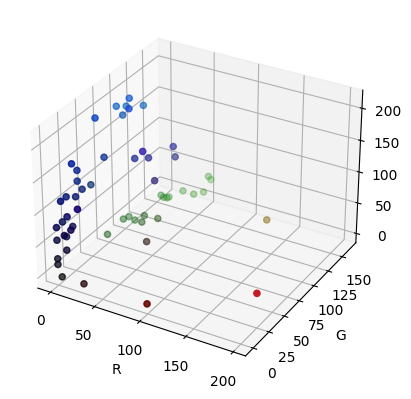

In [155]:
visualize_scatter(low_sim_colors_flatten)

- 추천된 템플릿 색상 분포 시각화

In [115]:
ids_list_set = np.array(list(set(ids_list)))

In [116]:
colors_arr_idx_adjust = np.array(colors_arr)[np.where(ids_list_set > 931, ids_list_set - 91, ids_list_set)]
colors_arr_idx_adjust_reshaped = colors_arr_idx_adjust.reshape(-1,3)

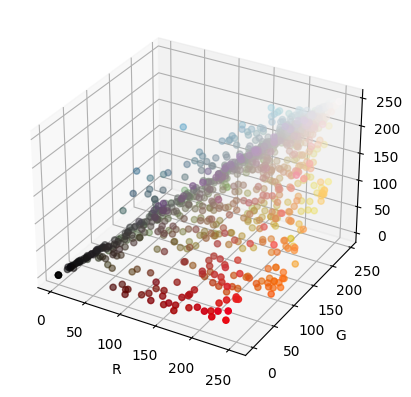

In [118]:
visualize_scatter(random.choices(colors_arr_idx_adjust_reshaped, k= 1000))

- 현재 템플릿 색상분포

In [119]:
selected_colors_arr = np.array(colors_arr)[np.random.choice(range(len(colors_arr)), 1015)]
template_colors_array = np.array(selected_colors_arr).reshape(-1,3)

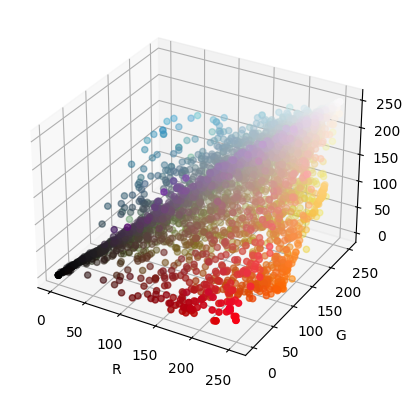

In [120]:
visualize_scatter(template_colors_array)

추천 템플릿 편향성 확인

- 템플릿 path 불러오기

In [358]:
from glob import glob
import os

template_paths = glob("/media/mlfavorfit/sdb/template/*/*.jpg")
template_dict = {int(os.path.basename(path).split(".")[0]):path for path in template_paths}

- 템플릿 별 추천 등장 빈도

In [359]:
from collections import Counter

count_recommend = dict(Counter(np.array(ids_list)))

print(f"등장한 템플릿 개수: {len(count_recommend)}/{len(template_dict)}, {len(count_recommend)/len(template_dict)*100:.2f}%")

등장한 템플릿 개수: 590/1015, 58.13%


<BarContainer object of 590 artists>

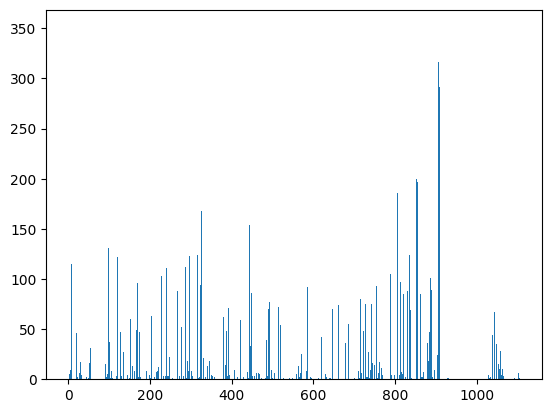

In [360]:
plt.bar(count_recommend.keys(), count_recommend.values())

In [361]:
from PIL import Image
def visualize_5_templates(top_5_template_id):
    for x, template_id in enumerate(top_5_template_id):
        template_path = template_dict[template_id]
        template_image = Image.open(template_path)

        plt.subplot(1, 5, x + 1)
        plt.axis('off')
        plt.imshow(template_image)

    plt.show()

- 많이 등장한 템플릿

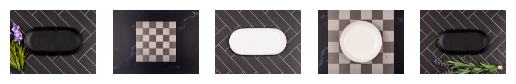

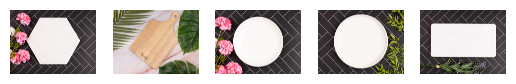

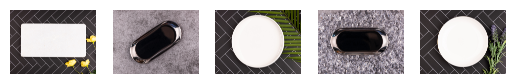

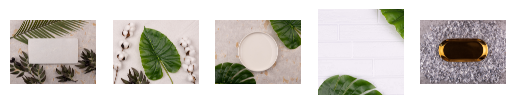

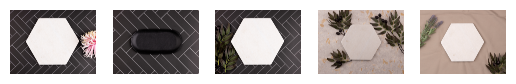

In [362]:
sorted_template_counter = sorted(count_recommend.items(), key=lambda x:x[1], reverse=True)
top_5_5_templates_matrix = np.array([cur[0] for cur in sorted_template_counter][:25]).reshape(-1,5)[:5]

for templates_5_list in top_5_5_templates_matrix:
    visualize_5_templates(templates_5_list)

In [363]:
ts = np.array([cur[0] for cur in sorted_template_counter[:50]])

temps = []
for data in datas:
    for t in ts:
        if t in data["id_0"]:
            temps.append(data["recommends_0"]) 

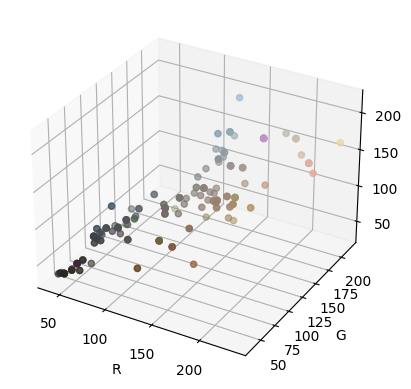

In [364]:
visualize_scatter(np.array(temps)[np.array([cur[0] for cur in sorted_template_counter[:50]])].reshape(-1,3))

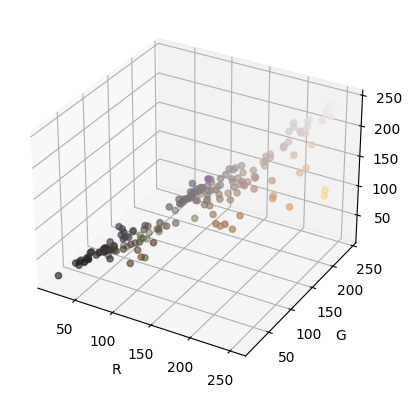

In [365]:
visualize_scatter(np.array(colors_arr)[np.array([cur[0] for cur in sorted_template_counter[:50]])].reshape(-1,3))

- Never used templates

In [366]:
template_indices = list(template_dict.keys())

for cur in count_recommend.keys():
    template_indices.remove(cur)

print("Never used templates number:", len(template_indices))

Never used templates number: 425


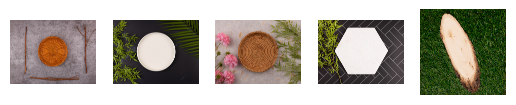

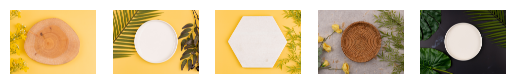

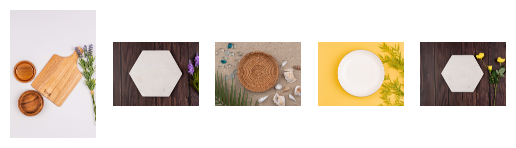

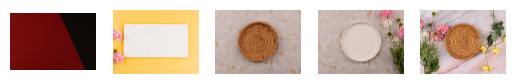

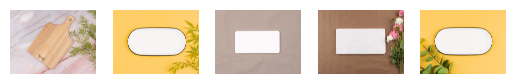

In [367]:
never_used_templates_5_5 = np.array(template_indices[:100]).reshape(-1,5)[:5]

for templates_5_list in never_used_templates_5_5:
    visualize_5_templates(templates_5_list)

## 색상 4개 추천 x2 => 8개 추천 결과 샘플

- 함수 정의

In [368]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bgr_colors(bgr_colors):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Loop through the list of BGR colors and plot each one
    for i, color in enumerate(bgr_colors):
        # Convert BGR to RGB and normalize to [0, 1]
        rgb_color = [x / 255.0 for x in reversed(color)]
        
        # Create a rectangle filled with the normalized RGB color
        rect = plt.Rectangle((i, 0), 1, 1, facecolor=rgb_color)
        
        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Set axis limits and aspect ratio
    ax.set_xlim(0, len(bgr_colors))
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

# visualize_bgr_colors([[35, 69, 99], [41, 55, 64], [96, 159, 183], [101, 141, 167]])

- 변수화

In [369]:
features_list = []
recommends_list = []
ids_list = []
fn_list = []

features_list2 = []
recommends_list2 = []
ids_list2 = []

for data in datas:
    fn = data["fn"]
    features = data["features_0"]
    recommends = data["recommends_0"]
    ids = data["id_0"][:template_recommend_num]

    # features2 = data["features_1"]
    # recommends2 = data["recommends_1"]
    # ids2 = data["id_1"][:template_recommend_num]

    fn_list.append(fn)
    
    features_list.extend(features)
    recommends_list.extend(recommends)
    ids_list.extend(ids)

    # features_list2.extend(features2)
    # recommends_list2.extend(recommends2)
    # ids_list2.extend(ids2)

In [370]:
np_feature = np.array(features_list).reshape(-1,4,3)
np_recommend = np.array(recommends_list).reshape(-1,4,3)
np_ids_list = np.array(ids_list).reshape(-1,template_recommend_num)

In [371]:
np_feature2 = np.array(features_list2).reshape(-1,4,3)
np_recommend2 = np.array(recommends_list2).reshape(-1,4,3)
np_ids_list2 = np.array(ids_list2).reshape(-1,template_recommend_num)

- 3개 샘플

In [374]:
sample_num = 3
random_index = np.random.randint(0, len(fn_list), sample_num)

- 시각화

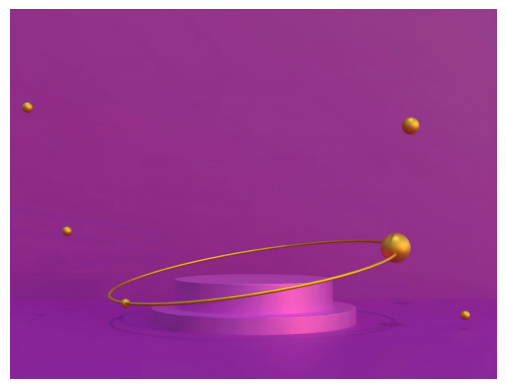

첫번째 4개 색상 - 상품 색상


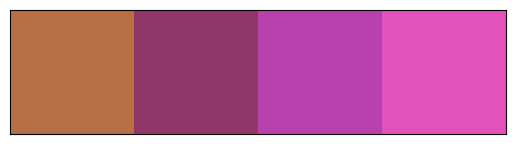

첫번째 4개 색상 - 추천 색상


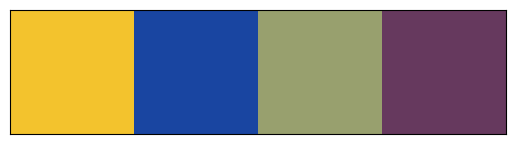

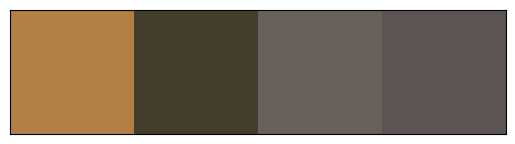

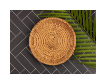

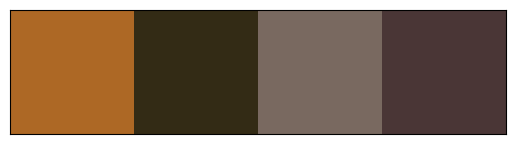

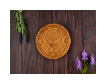

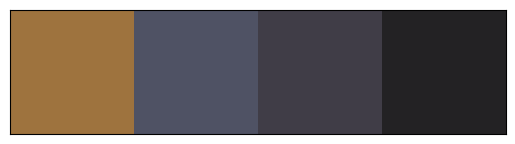

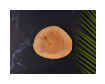

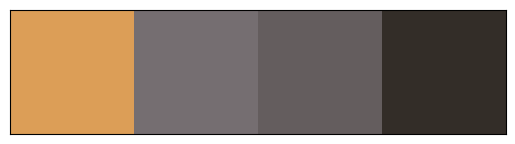

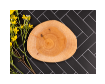

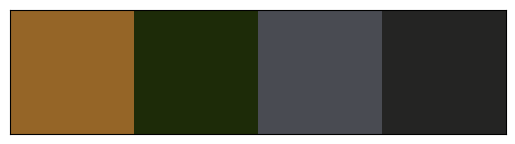

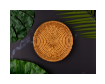

------------------------------------------------


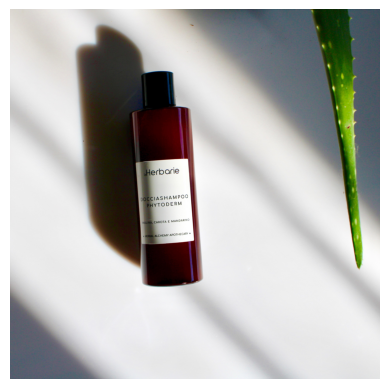

첫번째 4개 색상 - 상품 색상


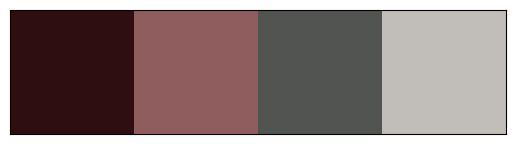

첫번째 4개 색상 - 추천 색상


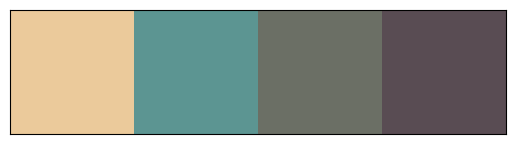

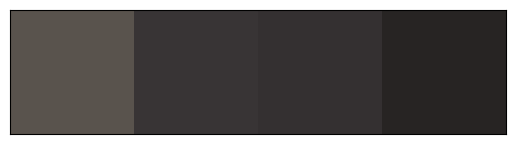

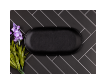

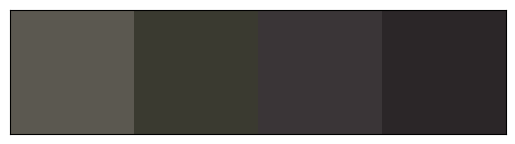

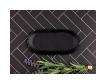

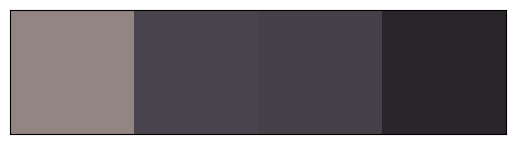

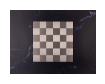

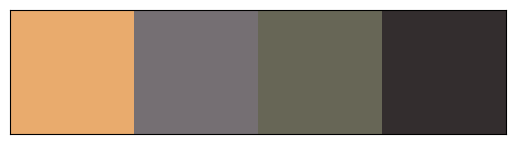

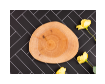

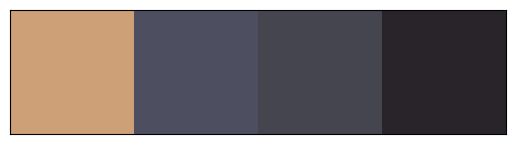

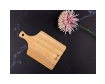

------------------------------------------------


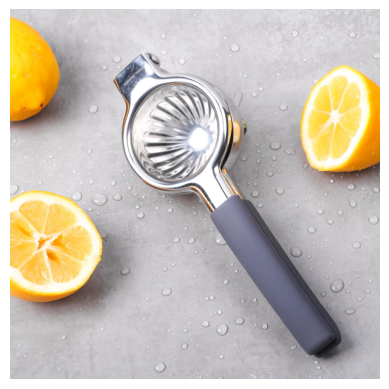

첫번째 4개 색상 - 상품 색상


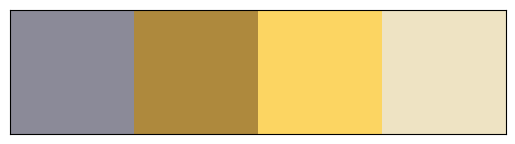

첫번째 4개 색상 - 추천 색상


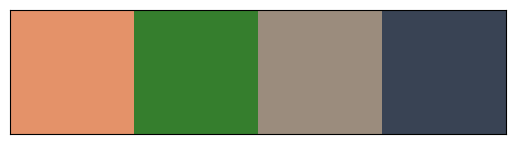

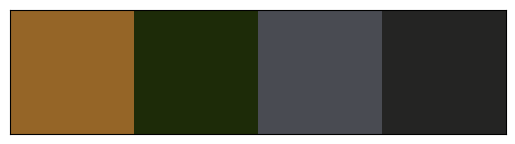

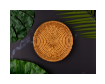

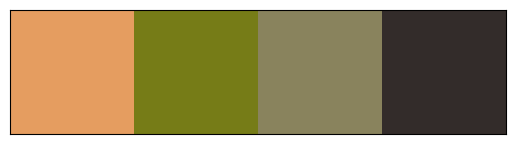

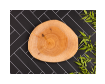

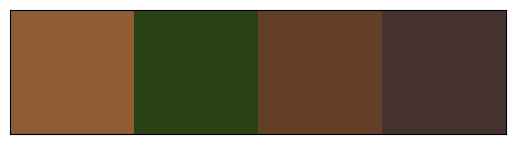

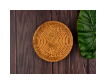

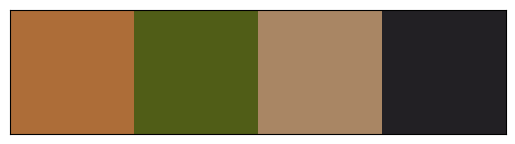

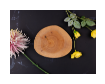

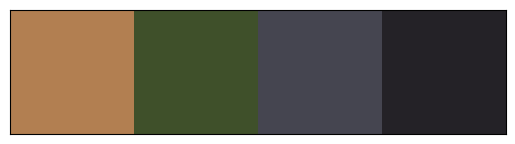

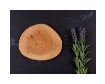

------------------------------------------------


In [375]:
sample_template_num = 5
for idx in random_index:
    image = Image.open(fn_list[idx])
    plt.axis('off')
    plt.imshow(image)
    plt.show()

    print("첫번째 4개 색상 - 상품 색상")
    visualize_bgr_colors(np_feature[idx])
    print("첫번째 4개 색상 - 추천 색상")
    visualize_bgr_colors(np_recommend[idx])

    # visualize template
    for i, template_id in enumerate(np_ids_list[idx][:sample_template_num]):
        template_path = template_dict[template_id]
        template_image = Image.open(template_path)
        # print(np.array(colors_arr[np.where(template_id > 931, template_id - 91, template_id)]).reshape(4,3))
        visualize_bgr_colors(np.array(colors_arr[np.where(template_id > 931, template_id - 91, template_id)]).reshape(4,3))

        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(template_image)

    plt.show()

    # print("두번째 4개 색상 - 상품 색상")
    # visualize_bgr_colors(np_feature2[idx])
    # print("두번째 4개 색상 - 추천 색상")
    # visualize_bgr_colors(np_recommend2[idx])

    # visualize template
    # for j, template_id in enumerate(np_ids_list2[idx][:sample_template_num]):
    #     template_path = template_dict[template_id]
    #     template_image = Image.open(template_path)

    #     plt.subplot(1, 5, j + 1)
    #     plt.axis('off')
    #     plt.imshow(template_image)

    # plt.show()
    
    print("------------------------------------------------")